# Introduction

##### This note book will do 2 things:

1- Analyze playlist's summary statistics

2- The algorithm will find the most similar track to the previous track. Therefore, the first track you enter will determine the entire set

##### Inputs:

1- Enter username and local address

2- Import json file(s)

3- Enter set duration and first track

###### Import Libraries

In [1]:
import urllib.request
from urllib.request import urlopen

import sys
import spotipy
import spotipy.util as util
import os
import json
import webbrowser
from json.decoder import JSONDecodeError

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from numpy import arange,array,ones
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns

# Set font scale
sns.set(font_scale=1.5)

import itertools

from scipy import optimize
from scipy.optimize import minimize

###### Expand Screen

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

##### User can add one or more playlists to combine a track pool

In [4]:
def import_data(file_name):
    json_file_name = file_name+'.json'
    raw_source = local_address + json_file_name

    with open(raw_source) as json_file:
        playlist_data = json.load(json_file)    
    
    return playlist_data

In [5]:
local_address = input('Enter local adress: ')

Enter local adress:  C:\Users\anhqu\OneDrive\Desktop\QAs\QA_dataset\


In [6]:
playlist_data = []
stop_importing = ''
file_name = ''

while stop_importing != 'y':
    file_name = input('Enter file name without .json: ')
    playlist_data.append(import_data(file_name))
    print('\n')
    print('Number of track imported from playlist: ' + str(len(import_data(file_name))))
    stop_importing = input('Enter y to stop importing. Otherwise enter anything: ')
    print('\n')

playlist_data = list(itertools.chain(*playlist_data))
print('Total Number of Track in Track pool: ' + str(len(playlist_data)))

Enter file name without .json:  anhquocduong611_ASOT_Trance_1_playlist_data




Number of track imported from playlist: 98


Enter y to stop importing. Otherwise enter anything:  


Enter file name without .json:  anhquocduong611_ASOT_Trance_1_playlist_data




Number of track imported from playlist: 98


Enter y to stop importing. Otherwise enter anything:  y




Total Number of Track in Track pool: 196


In [7]:
#https://thispointer.com/python-how-to-remove-duplicates-from-a-list/
def removeDuplicates(listofElements):
    
    # Create an empty list to store unique elements
    uniqueList = []
    
    # Iterate over the original list and for each element
    # add it to uniqueList, if its not already there.
    for elem in listofElements:
        if elem not in uniqueList:
            uniqueList.append(elem)
    
    # Return the list of unique elements        
    return uniqueList

In [8]:
playlist_data = removeDuplicates(playlist_data)
print('Total Number of Track in Track pool: ' + str(len(playlist_data)))

# Body Script

### Get Summary Statistics about the Playlist

In [9]:
audio_data_point = ['track_name', 'duration_ms', 'popularity', 'danceability', 
                    'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo',]

playlist_stats = dict.fromkeys(audio_data_point)

for data_point in audio_data_point:
    audio_stats = []
    for i in range(len(playlist_data)):
        audio_stats.append(playlist_data[i][data_point])
        playlist_stats[data_point] = audio_stats

In [10]:
data_point_plot = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'valence', 'tempo']
data_point_comb = list(itertools.combinations(data_point_plot, r=2))

#### More information about the data points

https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### Playlist Data Point Distribution

Writer's opinion: a homogeneous playlist will have normal distributions among Data Points

In [11]:
def hist_plot():
    print('Green line is average line')
    print('Red line is median line')
    fig = plt.figure(figsize=(30,30))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    fig.suptitle('Track pool Metrics Distribution', fontsize=20)
    for i in range(len(data_point_plot)):

        ax = fig.add_subplot(6,6,i+1)
        ax = sns.distplot(playlist_stats[data_point_plot[i]], bins='auto')

        # Draw average line
        ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).mean().item(), color='green', linestyle='dashed', linewidth=1)
        # Draw median line
        ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).median().item(), color='red', linestyle='dashed', linewidth=1)

        ax.set_xlabel(data_point_plot[i], color='tomato')
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
    return plt

Green line is average line
Red line is median line
<module 'matplotlib.pyplot' from 'C:\\Users\\anhqu\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


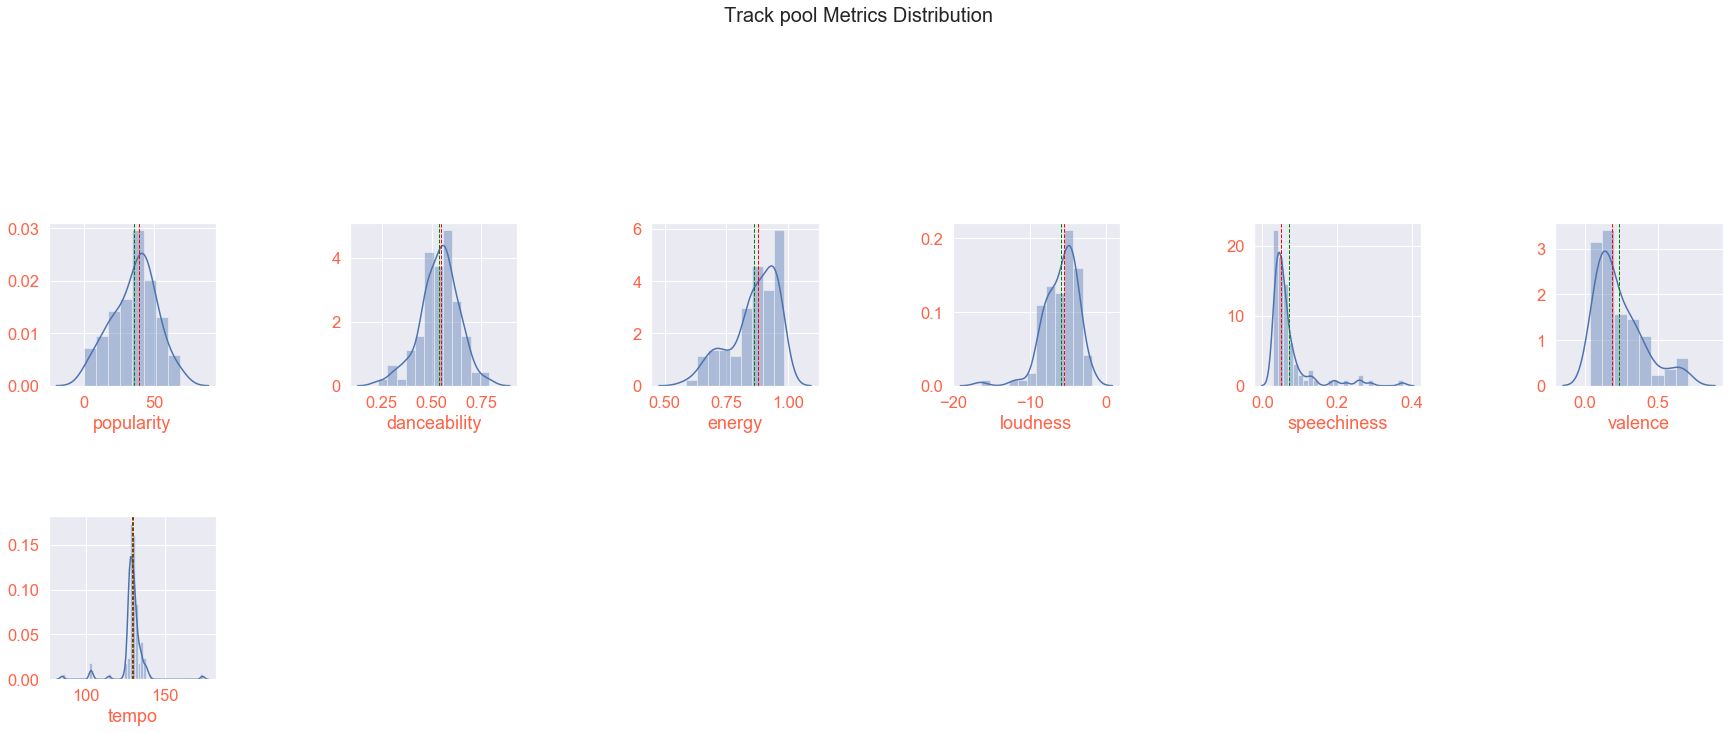

In [12]:
print(hist_plot())

### Correlation Between Data Points in the Playlist

In [13]:
def corre_plot():
    fig = plt.figure(figsize=(30,30))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    fig.suptitle('Correlation between Metrics', fontsize=20)

    for i in range(len(data_point_comb)):
        ax = fig.add_subplot(8,8,i+1)
        ax = sns.regplot(playlist_stats[data_point_comb[i][0]], playlist_stats[data_point_comb[i][1]])
        ax.set_xlabel(data_point_comb[i][0], color='tomato')
        ax.set_ylabel(data_point_comb[i][1], color='tomato')
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\anhqu\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


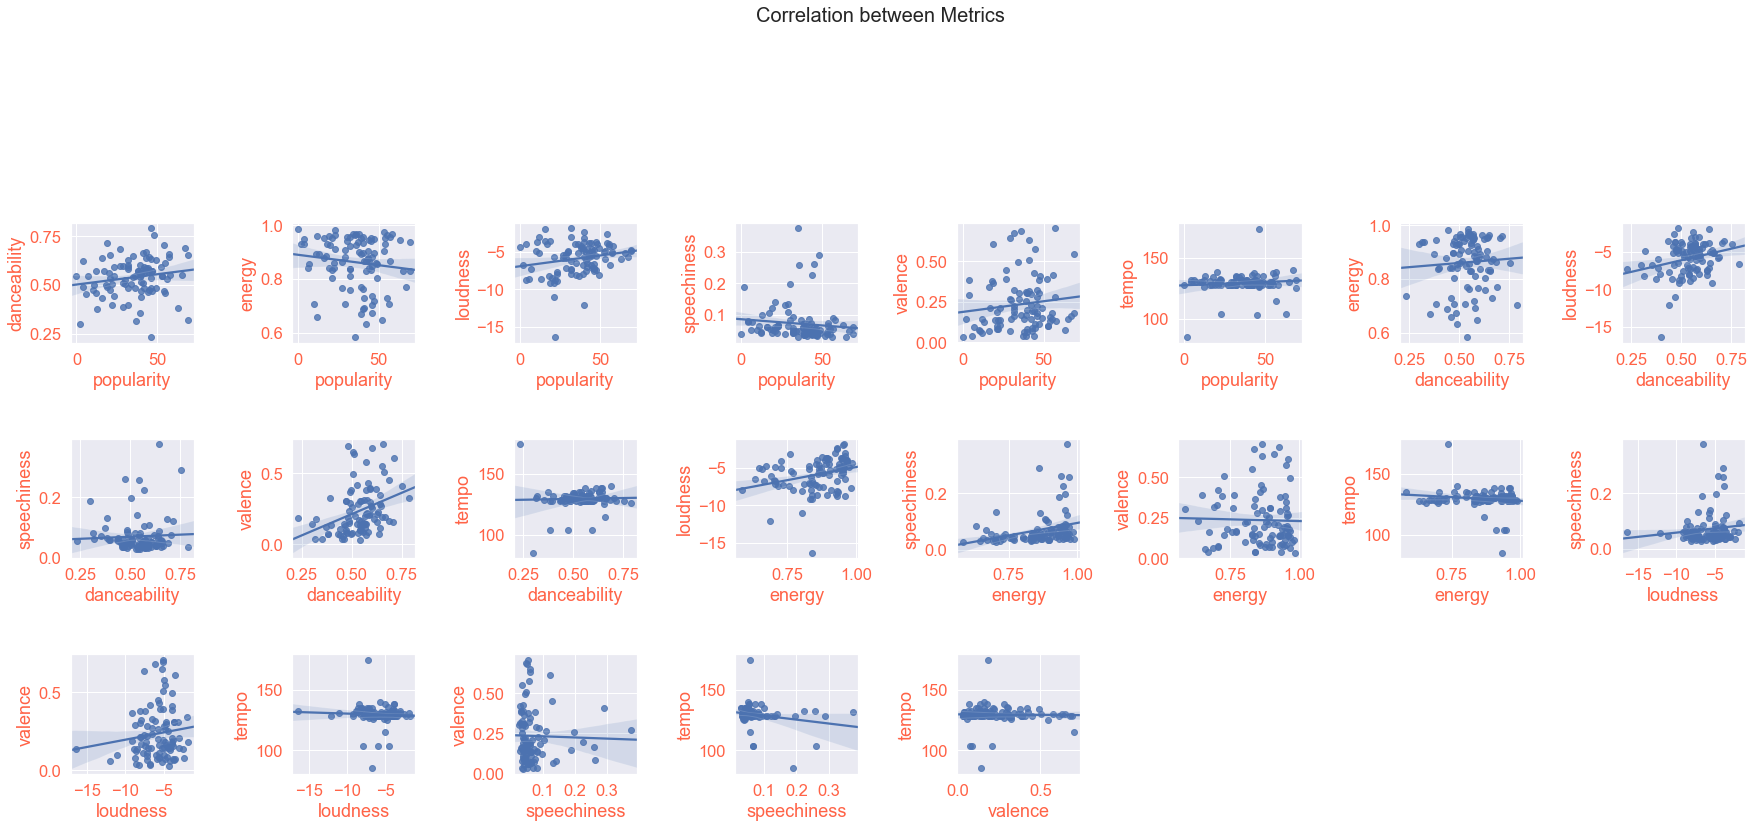

In [14]:
print(corre_plot())

###### Convert duration from seconds to minute

In [15]:
for i in range(len(playlist_data)):
    for z in range(len(playlist_data[i]['sections'])):
        playlist_data[i]['sections'][z]['start_minute'] = playlist_data[i]['sections'][z]['start']/60

In [16]:
def plot_track_mix(track_id_list):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] in track_id_list:
            track_index = i
    
    fig = plt.figure(figsize=(5,3))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
   
    # Plot title by Track name and Artist
    fig.suptitle(all_tracks_sections[track_index]['track_name'] + ' -- ' + all_tracks_sections[track_index]['artist'], color='tomato')

    for key, value in enumerate(track_metrics[1:3]):
        ax = fig.add_subplot(2,1,key+1)
        ax = sns.lineplot(all_tracks_sections[track_index]['start_minute'], all_tracks_sections[track_index][value])
        ax.set_ylabel(value, color='tomato', fontsize=18)
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
        # Plot average line
        ax.axhline(np.mean(all_tracks_sections[track_index][value]), color='green', linestyle='dashed', linewidth=1)
        # Plot Section breakout line
        for i in range(len(all_tracks_sections[track_index]['start_minute'])):
            ax.axvline(all_tracks_sections[track_index]['start_minute'][i], color='purple', linestyle='dashed', linewidth=1)

    ax.set_xlabel('time', color='tomato')
    # ax.text(1, 1, 'Green line is Average \n Purple line is Section', transform=ax.transAxes, fontsize=14,verticalalignment='bottom', color='tomato')

### Create new data points

Note: currently I'm not using these data points but it might be helpful once Spotify allows developers to modify playback (or I figure out how to) to transit tracks better

In [17]:
for i in range(len(playlist_data)):
    # Duration of 1st Section
    playlist_data[i]['duration_1st_section'] = playlist_data[i]['sections'][0]['duration']
    # Duration of last Section
    playlist_data[i]['duration_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['duration']
   
    # Tempo of 1st Section
    playlist_data[i]['tempo_1st_section'] = playlist_data[i]['sections'][0]['tempo']
    # Tempo of last Section
    playlist_data[i]['tempo_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['tempo']  
    
    # Key of 1st Section
    playlist_data[i]['key_1st_section'] = playlist_data[i]['sections'][0]['key']
    # Key of last Section
    playlist_data[i]['key_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['key']   
    
    # Modality of 1st Section
    playlist_data[i]['modality_1st_section'] = playlist_data[i]['sections'][0]['mode']
    # Modality of last Section
    playlist_data[i]['modality_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['mode']
   
    # Tempo of 2nd Section
    playlist_data[i]['tempo_2nd_section'] = playlist_data[i]['sections'][1]['tempo']
    # Tempo of 2nd last Section
    playlist_data[i]['tempo_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['tempo']  
    
    # Key of 2nd Section
    playlist_data[i]['key_2nd_section'] = playlist_data[i]['sections'][1]['key']
    # Key of 2nd last Section
    playlist_data[i]['key_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['key']     
    
    # Modality of 2nd Section
    playlist_data[i]['modality_2nd_section'] = playlist_data[i]['sections'][1]['mode']
    # Modality of 2nd last Section
    playlist_data[i]['modality_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['mode']
    
    # Loudness of 2nd Section
    playlist_data[i]['loudness_2nd_section'] = playlist_data[i]['sections'][1]['loudness']
    # Loudness of 2nd last Section
    playlist_data[i]['loudness_2ndlast_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-2]['loudness']

So the goal is the ending of the previous track last second will end at the end of the first section of the next track plus 1 second

In [18]:
track_transition_data = ['duration_1st_section','duration_1st_section','duration_1st_section','duration_1st_section','tempo_1st_section','tempo_last_section',
                        'key_1st_section','key_last_section','modality_1st_section','modality_last_section','loudness_1st_section','loudness_last_section',
                        'tempo_2nd_section','tempo_2ndlast_section','key_2nd_section','key_2ndlast_section','loudness_2nd_section','loudness_2ndlast_section']

In [19]:
def track_playlist_index(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
            return track_index
            break
    print('Not Found')

### Optimization: Find the perfect next track

### Functions to Select the Best Track

1 - Harmonic keys

2 - Tempo

3 - Energy level

4 - Valence level

5 - Danceability level

6 - Popularity level

### Camelot Key Harmony Mixing

Camelot Key is a techinque to select a track that sounds harmonically well with the previous track

https://www.reddit.com/r/Beatmatch/comments/1q1pbo/the_rules_of_harmonic_mixing/

In [20]:
def get_list_info(dataset, data_point):
    data_point_list = [dataset[i][data_point] for i in range(len(dataset))]
    return data_point_list

In [21]:
def track_keys_input(track_id):
    track_keys = dict.fromkeys(['key', 'mode'])
    track_keys.update(key=playlist_data[track_playlist_index(track_id)]['key'])
    track_keys.update(mode=playlist_data[track_playlist_index(track_id)]['mode'])
    return track_keys

In [22]:
def camelot_system(track_keys):
    harmonic_keys = dict.fromkeys(['key', 'mode'])
    # Stay in the same key 4A 4A
    same_key = harmonic_keys.copy() 
    same_key['key'] = track_keys['key']
    same_key['mode'] = track_keys['mode']
    same_key_list = ['same_key', same_key]
    
    # Move up one 4A 5A
    one_key_up = harmonic_keys.copy()
    one_key_up['key'] = track_keys['key']+1 if track_keys['key']!= 12 else 1
    one_key_up['mode'] = track_keys['mode']
    one_key_up_list = ['one_key_up', one_key_up]
    
    # Move down one 4A 3A
    one_key_down = harmonic_keys.copy()
    one_key_down['key'] = track_keys['key']-1 if track_keys['key']!= 1 else 12
    one_key_down['mode'] = track_keys['mode']
    one_key_down_list = ['one_key_down', one_key_down]
    
    # Move major 4A 4B
    change_major = harmonic_keys.copy()
    change_major['key'] = track_keys['key']
    change_major['mode'] = abs(track_keys['mode']-1)
    change_major_list = ['change_major', change_major]
    
    # Move major +3 4A 7B
    change_major_3 = harmonic_keys.copy()
    change_major_3['key'] = track_keys['key']+3 if track_keys['key']<10 else track_keys['key']-9
    change_major_3['mode'] = abs(track_keys['mode']-1)
    change_major_3_list = ['change_major_3', change_major_3]
    
    # Move up minor -3 4A 1A
    up_minor_3 = harmonic_keys.copy()
    up_minor_3['key'] = track_keys['key']-3 if track_keys['key']>4 else track_keys['key']+9
    up_minor_3['mode'] = track_keys['mode']
    up_minor_3_list = ['up_minor_3', up_minor_3]
    
    # Half step 4A 11A
    half_step = harmonic_keys.copy()
    half_step['key'] = track_keys['key']+7 if track_keys['key']<6 else track_keys['key']-5
    half_step['mode'] = track_keys['mode']
    half_step_list = ['half_step', half_step]
    
    # Whole step 4A 6A
    whole_step = harmonic_keys.copy()
    whole_step['key'] = track_keys['key']+2 if track_keys['key']<11 else track_keys['key']-10
    whole_step['mode'] = track_keys['mode']
    whole_step_list = ['whole_step', whole_step]
    
    # Domniant key 4A 5B
    dominant_key = harmonic_keys.copy()
    dominant_key['key'] = track_keys['key']+1 if track_keys['key']!=12 else 1
    dominant_key['mode'] = abs(track_keys['mode']-1)
    dominant_key_list = ['dominant_key', dominant_key]
    
    harmonic_keys_list = [same_key_list, one_key_up_list, one_key_down_list, change_major_list, change_major_3_list, up_minor_3_list, half_step_list, whole_step_list, dominant_key_list]
    return harmonic_keys_list

In [23]:
def camelot_explained(key_name, mode):
    if key_name == 'same_key':
        return 'same emotion'
   
    if key_name == 'one_key_up':
        return 'raise energy'
    
    if key_name == 'one_key_down':
        return 'same emotion'
    
    if key_name == 'change_major' and mode == 0:
        return 'brighten'
    if key_name == 'change_major' and mode == 1:
        return 'darken'
    
    if key_name == 'change_major_3' and mode == 0:
        return 'brighten'
    if key_name == 'change_major_3' and mode == 1:
        return 'darken'
    
    if key_name == 'up_minor_3':
        return 'raise energy'
    
    if key_name == 'half_step':
        return 'raise energy'
    
    if key_name == 'whole_step':
        return 'raise energy'
    
    if key_name == 'dominant_key' and mode == 0:
        return 'brighten'
    
    if key_name == 'dominant_key' and mode == 1:
        return 'darken'

In [24]:
def harmonic_tracks(track_index):
    # Apply Camelot Function to get harmonic keys
    camelot_raw = camelot_system(track_keys_input(playlist_data[track_index]['track_id']))
    camelot_list = [camelot_raw[i][1] for i in range(len(camelot_raw))]
    tracks = []
    for y in range(len(playlist_data)):
        if track_keys_input(playlist_data[y]['track_id']) in camelot_list:
            for i in range(len(camelot_raw)):
                if playlist_data[y]['key'] == camelot_raw[i][1]['key'] and playlist_data[y]['mode'] == camelot_raw[i][1]['mode']:
                    tracks.append((playlist_data[y]['track_id'],
                                   playlist_data[y]['track_name'], 
                                   camelot_raw[i], 
                                   camelot_explained(camelot_raw[i][0], playlist_data[track_index]['mode'])))
    return tracks

### Track Metrics Similarity

In [25]:
def next_tracks_selection(previous_track_index):
    next_track_list = pd.DataFrame(harmonic_tracks(previous_track_index))
    next_track_list.columns = ['track_id', 'track_name', 'keys', 'emotion_change']
    
    # The playlist in this loop removes any previous tracks. This playlist is different that the raw playlist

    for y in metrics_no_popularity:
        for i in range(len(next_track_list)):
            next_track_list.loc[i,y+'%'] = round((playlist_data[track_playlist_index(next_track_list.loc[i,'track_id'])][y] - playlist_data[previous_track_index][y])*100/ \
                                             playlist_data[previous_track_index][y],2) # add small value to avoid zero division which is rare
    next_track_list['total%'] = next_track_list.iloc[:, 4:8].sum(axis=1)
    # Drop the current track
    next_track_list.drop(next_track_list.loc[next_track_list['total%']==0].index, inplace=True)
    next_track_list = next_track_list.reset_index(drop=True)
    
    # Drop tracks that are already selected
    for i in range(len(next_track_list)):
        if next_track_list.loc[i,'track_id'] in get_list_info(tracks_order, 'track_id'):
            next_track_list.drop(i, inplace=True)
    next_track_list = next_track_list.reset_index(drop=True)
    
    return next_track_list

In [26]:
def best_next_track(previous_track_index):
    # Print the Previous Track Name, Key Mode
    print('Previous track: ' + '\033[1m' + str(playlist_data[previous_track_index]['track_name']) + '\033[0m')
    print('Key&Mode: ', ('key', playlist_data[previous_track_index]['key']), ('mode', playlist_data[previous_track_index]['mode']))
    
    # Apply the next track selection function
    next_track_list = next_tracks_selection(previous_track_index)
    
    # Find the top 3 most similar tracks
    # https://stackoverflow.com/questions/13070461/get-index-of-the-top-n-values-of-a-list-in-python
    # random top track is an input to select how many top similar tracks should the model populates, then select one random from it
    
    best_next_track_indices = sorted(range(len(abs(next_track_list['total%']))), key=lambda i: abs(next_track_list['total%'])[i])[:random_top_track] 
   
    # Select randomly one index from the top 3
    import random
    best_next_track_index = random.choice(best_next_track_indices)
    
    # Get the emotion change 
    emotion_change = next_track_list.loc[best_next_track_index, 'emotion_change']
    
    # Print the Next Track name, Key Mode and Mood change
    print('Next track: ' + '\033[1m' + str(next_track_list.loc[best_next_track_index, 'track_name']) + '\033[0m')
    print('Key&Mode: ', next_track_list.loc[best_next_track_index, 'keys'])
    print('Mood change: ', camelot_explained(key_name=next_track_list.loc[best_next_track_index, 'keys'][0],
                                            mode=next_track_list.loc[best_next_track_index, 'keys'][1]['mode']))
    
    # Print similarity result
    print_out = []
    for i in metrics_no_popularity:
        print_out.append((i, next_track_list.loc[best_next_track_index, i+'%']))
    print_out.append(('total % delta', round(next_track_list.loc[best_next_track_index, 'total%'],2)))
    print('Similarity % delta:' + str(print_out))

    # Return track id
    next_track_id = next_track_list.loc[best_next_track_index, 'track_id']
    return next_track_id, emotion_change

# Create the perfect mix set from my Spotify Playlist by Python

## Input:

### Set Time

In [27]:
set_time_input = input('Enter set time: ')
set_time_input = int(set_time_input)

Enter set time:  90


### First Track

Note: the first track will set up the entire mix

In [28]:
print([[key, playlist_data[key]['track_name']] for key in range(len(playlist_data))])
previous_track_index = input('Enter first track: ')
previous_track_index = int(previous_track_index)

[[0, 'A State Of Trance [ASOT 610] - Outro'], [1, 'Call To Arms - Cosmic Gate Remix'], [2, "Exploration Of Space (ASOT 758) - Cosmic Gate's Third Contact Remix"], [3, 'Past All Regrets (ASOT 794) [Tune Of The Week]'], [4, 'United'], [5, 'My Reflection'], [6, 'We Are Here To Make Some Noise'], [7, 'Particle Arts'], [8, 'Will We Remain? - Spencer Brown Remix'], [9, 'Living On The Edge'], [10, 'Intense'], [11, 'Mirage'], [12, 'Off The Hook'], [13, 'Alone'], [14, 'Another You'], [15, 'Drowning - Avicii Remix'], [16, 'Blah Blah Blah'], [17, 'Be In The Moment (ASOT 850 Anthem)'], [18, 'Saving Light'], [19, 'Great Spirit'], [20, 'Ping Pong'], [21, 'Iconic'], [22, 'Caesarea'], [23, 'Ends Of Time'], [24, 'If Not Now - Club Mix'], [25, 'The Spirit Of The Warrior - Davey Asprey Remix'], [26, 'In The Dark'], [27, 'Let Me Know'], [28, 'Zoom'], [29, 'Oracle'], [30, 'You Are'], [31, 'Heading Up High - First State Remix'], [32, 'Chakra'], [33, 'Xplode - Graham Bell & Yoel Lewis Remix'], [34, 'This Is 

Enter first track:  97


### Random seed for next track 

Note: The algorithm will select the top n tracks similar to the previous track, then it will randomly select one. As the result, the higher n number you put it the more random the track is going to be. If the random seed is 1, the next track will be the most similar track to the previous one

This mechanism will help create unique mix everytime you run the script.

In [29]:
import random
print("Select random seed value for next track. If the random seed is 1, the next track will be the most similar track to the previous one. If you select 3 for example, the algorithm will select randomly a track among the top 3 most similar tracks. The higher n seed value, the more random the next track is going to be. Type 'random' will make the seed random from 1 to 3 for each loop of selecting the next best track: ")
random_top_track_input = input("Insert a seed number or type random")

Select random seed value for next track. If the random seed is 1, the next track will be the most similar track to the previous one. If you select 3 for example, the algorithm will select randomly a track among the top 3 most similar tracks. The higher n seed value, the more random the next track is going to be. Type 'random' will make the seed random from 1 to 3 for each loop of selecting the next best track: 


Insert a seed number or type random 1


### Playlist's Summary statistics

#### Calculate Total Duration of the Playlist

In [30]:
def convert_ms(milli):
    seconds=(milli/1000)%60
    minutes=(milli/(1000*60))%60
    hours=(milli/(1000*60*60))%24
    
    hour_read = str(int(hours))+':'+str(int(minutes))+':'+str(int(seconds))
    minute_read = round(int(hours)*60 + minutes, 2)
    return hour_read, minute_read

In [31]:
playlist_duration_ms = 0
for i in range(len(playlist_data)):
    playlist_duration_ms += playlist_data[i]['duration_ms']
    playlist_data[i]['duration_minute'] = convert_ms(playlist_data[i]['duration_ms'])[1]
    playlist_duration = convert_ms(playlist_duration_ms)
print('Playlist total length: ')
print(playlist_duration)

Playlist total length: 
('6:11:34', 371.57)


# Execution Script

In [32]:
previous_track = playlist_data[previous_track_index]
tracks_order = [previous_track]

set_duration = 0
i = 0
emotion_change_list = ['start']

metrics = ['tempo', 'danceability', 'energy', 'valence', 'popularity']
# Popularity is not included in the similarity score, so this variable will be used in the function to find next best track
# However, popularity is still going to be plotted so it's kept in the original metrics list
metrics_no_popularity = metrics.copy()
try:
    metrics_no_popularity.remove('popularity')
except:
    pass

while set_duration <= set_time_input:
    
    # Random seed
    if random_top_track_input == 'random':
        random_top_track = random.randint(1,3)
    else: 
        random_top_track = int(random_top_track_input)
    
    previous_track = playlist_data[previous_track_index]
    previous_track_sections = previous_track['sections']

    # Apply function to get track id, then find the track index in the playlist
    select_next_track = best_next_track(previous_track_index)
    next_track_index = track_playlist_index(select_next_track[0])
    next_track = playlist_data[next_track_index]
    
    print('Random seed: ' + str(random_top_track))
    print('Next track index: ' + str(next_track_index))
    print('\n')

    tracks_order.append(next_track)
    emotion_change_list.append(select_next_track[1])
    
    # Calculate total time of the set
    set_duration += tracks_order[i]['duration_minute']
    
    # Next iteration
    i+=1

    previous_track_index = next_track_index
    
print('Total set time: ' + str(round(set_duration,2)))
print('Number of Tracks: ' + str(len(tracks_order)))
print('\n')

Previous track: La Résistance De L'Amour
Key&Mode:  ('key', 7) ('mode', 0)
Next track: Violet (Mix Cut)
Key&Mode:  ['up_minor_3', {'key': 4, 'mode': 0}]
Mood change:  raise energy
Similarity % delta:[('tempo', 3.15), ('danceability', -26.65), ('energy', -13.55), ('valence', 33.66), ('total % delta', -3.39)]
Random seed: 1
Next track index: 37


Previous track: Violet (Mix Cut)
Key&Mode:  ('key', 4) ('mode', 0)
Next track: Black Eagle - Radio Edit
Key&Mode:  ['change_major_3', {'key': 7, 'mode': 1}]
Mood change:  darken
Similarity % delta:[('tempo', -1.54), ('danceability', 33.58), ('energy', 13.3), ('valence', -41.63), ('total % delta', 3.71)]
Random seed: 1
Next track index: 44


Previous track: Black Eagle - Radio Edit
Key&Mode:  ('key', 7) ('mode', 1)
Next track: Living On The Edge
Key&Mode:  ['half_step', {'key': 2, 'mode': 1}]
Mood change:  raise energy
Similarity % delta:[('tempo', -1.54), ('danceability', 4.69), ('energy', -2.2), ('valence', 4.06), ('total % delta', 5.01)]
Rando

### Plot Set

In [33]:
# Get Set info
set_track_name = get_list_info(tracks_order, 'track_name')
set_track_id =  get_list_info(tracks_order, 'track_id')
set_time =  get_list_info(tracks_order, 'duration_minute')
set_energy = get_list_info(tracks_order, 'energy')
set_artist = get_list_info(tracks_order, 'artist')

In [34]:
# Create Culmulative Set Time
set_time_cum = []
for i in range(len(tracks_order)):
    set_time_cum.append(tracks_order[i]['duration_minute'])
set_time_cum = list(np.cumsum(set_time_cum))
set_time_cum = [float(round(set_time_cum[i],2)) for i in range(len(tracks_order))]
# Remove the last set time
set_time_cum.pop()
# Add 0 to the set
set_time_cum.insert(0,0)

# Create Metrics list for the set
set_metrics = dict.fromkeys(metrics)
for y in range(len(metrics)):
    set_metrics[metrics[y]] = [tracks_order[i][metrics[y]] for i in range(len(tracks_order))]

color_array = []
for i in range(len(emotion_change_list)):
    if emotion_change_list[i] == 'raise energy':
        color_array.append('salmon')
    if emotion_change_list[i] == 'brighten':
        color_array.append('lightsteelblue')
    if emotion_change_list[i] == 'darken':
        color_array.append('grey')
    if emotion_change_list[i] == 'same emotion':
        color_array.append('mediumaquamarine')
    if emotion_change_list[i] == 'start':
        color_array.append('gold')
color_array = tuple(color_array)

### Plot Metrics

In [35]:
def set_metrics_plot(metrics):
    height = get_list_info(tracks_order, metrics)
    width = set_time 
    y_pos = set_time_cum
    
    plt.bar(y_pos, height, width=width, align='edge', color=color_array)
    
    plt.tick_params(axis='x', colors='tomato')
    plt.tick_params(axis='y', colors='tomato')
    plt.xticks(np.arange(round(min(set_time_cum)), round(max(set_time_cum))+5, 5.0))
    # Adjust range axis
    plt.ylim([min(height)-max(height)/10 if (min(height)-max(height)/10)>0 else 0, max(height)+min(height)/10])
    
    plt.axhline(np.mean(height), color='green', linestyle='dashed', linewidth=1)
    plt.ylabel(metrics, color='tomato', fontsize=15)
    #plt.xlabel('minute', color='tomato', fontsize=15)
    plt.title(metrics, color='tomato', fontsize=15)
    
    # Line separate tracks
    for i in range(len(set_time_cum)):
        plt.axvline(set_time_cum[i], color='grey', linestyle='dashed', linewidth=1)
        
    # Track index on top of bar
    for key, value in enumerate(set_time_cum):
        plt.text(y_pos[key], height[key], key, color='purple')
    
    return plt

### Plot Loudness Line

In [36]:
all_tracks_sections = []
track_metrics_dict = [0,0,0,0,0,0,0]
track_metrics = ['loudness', 'tempo', 'duration']

for x in range(len(tracks_order)):
    track_metrics_dict[0] = tracks_order[x]['track_name']
    track_metrics_dict[1] = tracks_order[x]['track_id']
    track_metrics_dict[2] = tracks_order[x]['artist']
    track_metrics_dict[3] = tracks_order[x]['album']
    # For each metric
    for key, value in enumerate(track_metrics):
        # Reset the list that collects data point 
        track_sections_data = []        
        # For each metric, loop by the number of sections in the track
        for z in range(len(tracks_order[x]['sections'])):
            # Add data point to a list
            track_sections_data.append(tracks_order[x]['sections'][z][value])
            # Add the list to a dict of track data points
            track_metrics_dict[key+4] = track_sections_data
    # Add the dict to a list of tracks
    all_tracks_sections.append(track_metrics_dict)
    track_metrics_dict = [0,0,0,0,0,0,0]

In [37]:
def plot_track(set_track_id):
    time = []
    loudness = []
    for i in range(len(all_tracks_sections)):
        if all_tracks_sections[i][1] in set_track_id:
            time.append(all_tracks_sections[i][6])
            loudness.append(all_tracks_sections[i][4])   

    time_flat = list(itertools.chain(*time))
    time_cum = np.cumsum(time_flat)
    time_cum = [time_cum[i]/60 for i in range(len(time_cum))]

    loudness_flat = list(itertools.chain(*loudness))

    fig = plt.figure(figsize=(25,5))

    # Plot title by Track name and Artist
    fig.suptitle('Loudness', color='tomato', fontsize=15)

    ax = sns.lineplot(time_cum, loudness_flat)

    ax.set_ylabel('Loudness', color='tomato')
    ax.tick_params(axis='x', colors='tomato')
    ax.tick_params(axis='y', colors='tomato')
    plt.ylim([-30, 0])

    # Plot Section breakout line
    for i in range(len(set_time_cum)):
        plt.axvline(set_time_cum[i], color='grey', linestyle='dashed', linewidth=1)

    ax.set_xlabel('time', color='tomato')
    
    for key in range(len(set_track_id)):
        plt.text(set_time_cum[key], 0, key, color='purple')
    
    return plt

## Plot: Set Mix

Set Mix Track Order: 


0 ("La Résistance De L'Amour", 'Armin van Buuren')
1 ('Violet (Mix Cut)', 'Armin van Buuren')
2 ('Black Eagle - Radio Edit', 'Frainbreeze')
3 ('Living On The Edge', 'JETFIRE')
4 ('A State Of Trance [ASOT 610] - Outro', 'Armin van Buuren ASOT Radio')
5 ('Free Tibet - Vini Vici Remix', 'Hilight Tribe')
6 ('Caesarea', 'Armin van Buuren')
7 ('There Is Light', 'Andy Moor')
8 ('In The Dark', 'Armin van Buuren ASOT Radio Top 20')
9 ('Getaway (ASOT 900 - Part 1) - Gareth Emery & Ashley Wallbridge Remix', 'Armin van Buuren ASOT Radio')
10 ("Exploration Of Space (ASOT 758) - Cosmic Gate's Third Contact Remix", 'Armin van Buuren ASOT Radio')
11 ('Let Me Know', 'Armin van Buuren ASOT Radio Top 20')
12 ('Tierra', 'KhoMha')
13 ('Be In The Moment (ASOT 850 Anthem)', 'Armin van Buuren')
14 ('Lifting You Higher (ASOT 900 Anthem) - Blasterjaxx Remix', 'Blasterjaxx')
15 ('The Spirit Of The Warrior - Davey Asprey Remix', 'Armin van Buuren ASOT Radio Top 20')
16 ('Particle Arts', 'V

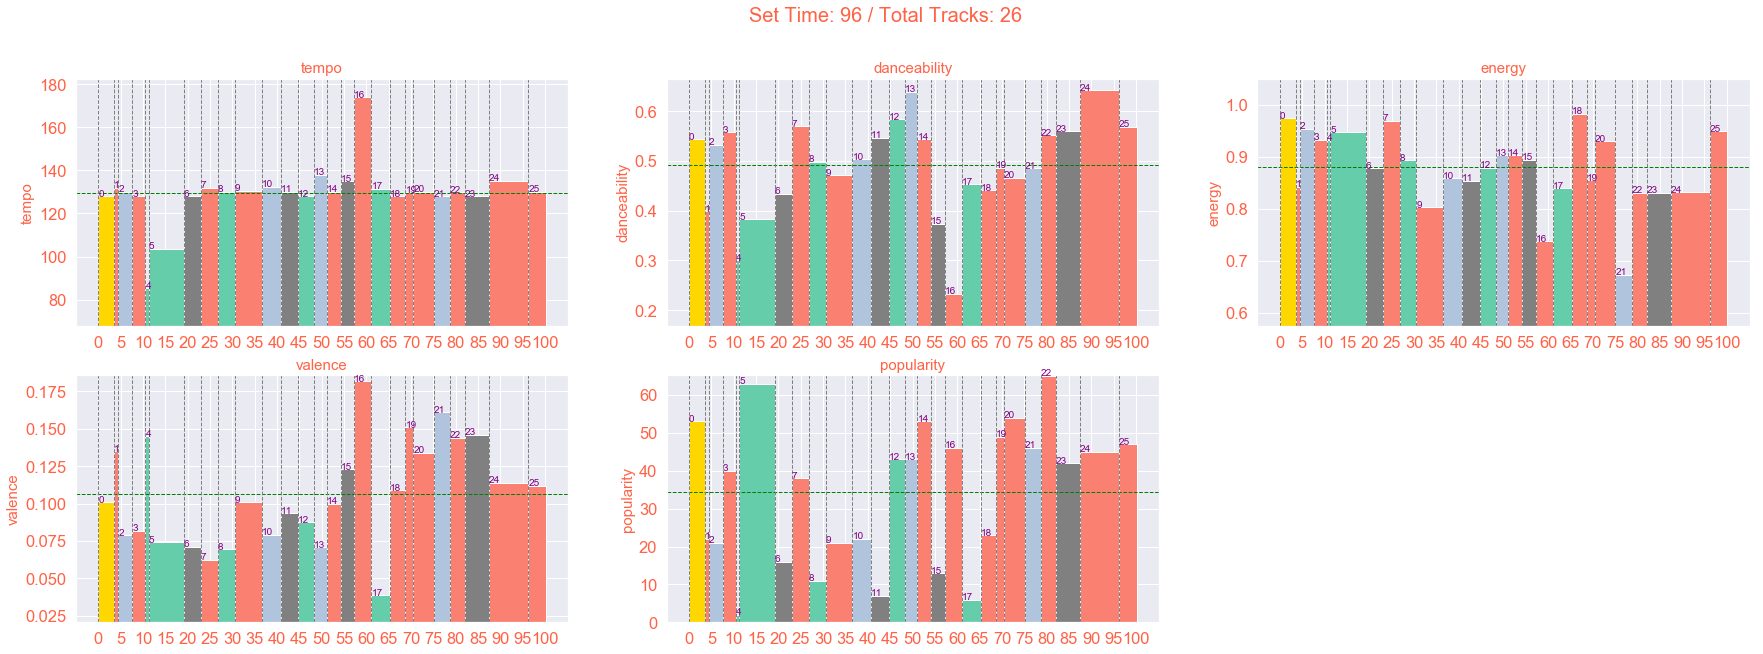

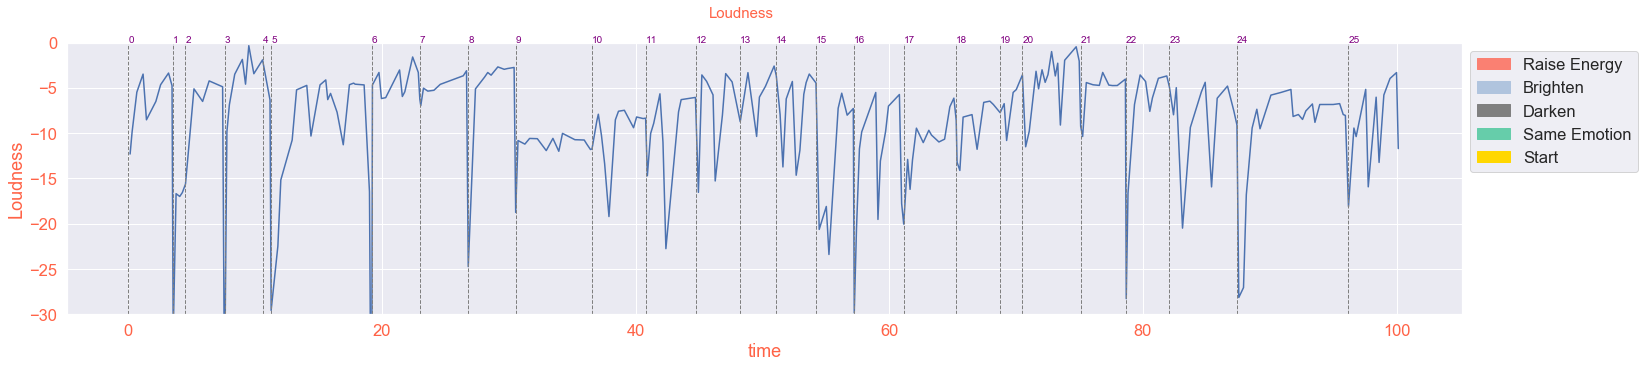

In [38]:
print('Set Mix Track Order: ')
print('\n')
for key, value in enumerate(zip(set_track_name, set_artist)):
    print(key, value)

fig = plt.figure(figsize=(30,10))
# Plot title by Track name and Artist
fig.suptitle('Set Time: ' +str(round(set_duration)) +' / Total Tracks: ' + str(len(tracks_order)), color='tomato', fontsize=20)
 
raise_energy = mpatches.Patch(color='salmon', label='Raise Energy')
brighten = mpatches.Patch(color='lightsteelblue', label='Brighten')
darken = mpatches.Patch(color='grey', label='Darken')
same_emotion = mpatches.Patch(color='mediumaquamarine', label='Same Emotion')
start = mpatches.Patch(color='gold', label='Start')
handles = [raise_energy, brighten, darken, same_emotion, start]

for i in range(len(metrics)):
    ax = fig.add_subplot(2,3,i+1)
    ax = set_metrics_plot(metrics[i]) 

plot_track(set_track_id)

plt.legend(handles=handles, bbox_to_anchor=(1, 1), ncol=1)
plt.show()